In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import importlib
import dask.dataframe as dd
import gc

gc.enable()


import matplotlib.pyplot as plt



# Local imports
#------------------------------------------------
import WireDAQ.PandasPlus           # Make sure this import is after pandas
import WireDAQ.Constants as cst
import WireDAQ.NXCALS as nx
import WireDAQ.Parser as parser
import WireDAQ.Efficiency as eff

main = __import__('000_Efficiency_per_fill')


# Creating NXCALS variable containers
#------------------------------------------------
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
LHC       = nx.NXCALSLHC()
b_slots   = np.arange(3564)
#------------------------------------------------


# Setting default values
#------------------------------------------------
_default_fig_width  = 2000
_default_fig_height = 400

_default_device = 'DBLM'

_default_import = 'local'
_default_path   = '/home/lumimod/work/run/data/2023/rawdata/'
_default_out    = '/eos/user/p/phbelang/www/Monitoring_BBCW/'


_default_path = '/home/phbelang/002_raw_data'

#------------------------------------------------

# display(pd.DataFrame(gc.get_stats()))




>>> Loading nx2pd.py version of 24.10.2022 @ 03:17PM



2023-05-25 17:09:59,983 [INFO] 
Limited Total Variation Regularization Support Detected! 
---> CVXPY is not installed. 
---> Many Total Variation Methods require CVXPY including: 
---> velocity, acceleration, jerk, jerk_sliding, smooth_acceleration
---> Please install CVXPY to use these methods.
---> Recommended to also install MOSEK and obtain a MOSEK license.
You can still use: total_variation_regularization.iterative_velocity

2023-05-25 17:09:59,986 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2023-05-25 17:09:59,987 [INFO] 
Limited Linear Model Support Detected! 
---> CVXPY is not installed. 
---> Install CVXPY to use lineardiff derivatives 
You can still use other methods 



---
# Dask, computing efficiency
---

In [2]:
def fill_unix_times(fill,data_path=_default_path):
    _df = dd.read_parquet(data_path + f'/HX:FILLN={fill}',columns=[LHC.Fill]).compute()
    _df = _df.sort_index()
    return _df.index[0],_df.index[-1]

In [3]:
# Importing the library
import psutil
 
# Getting % usage of virtual_memory ( 3rd field)
print(40*'-' + '\nBefore')
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)


FILL        = 8773
import_from = 'local'

data_path= _default_path
fill     = FILL
dt       = 10
baseline = None



unix_s,unix_e = fill_unix_times(fill,data_path=data_path)
unix_bins     = np.arange(unix_s,unix_e,dt/1e-9)

# STARTS HERE
#=================================================

per_beam_list = []
for beam in beams:
    # if beam.name == 'B1':
    #     continue
    
    # Variables for this beam
    variables = [beam['dBLM_Amp']['V'],
                 beam['dBLM_Amp']['H-V-S']]
    
    # Iterate through bmode
    per_mode_list = []
    for bmode_path in Path(data_path + f'/HX:FILLN={fill}').glob("*"):
        # just for testing
        # if 'STABLE' not in str(bmode_path):
        #     continue

        
        _partition = dd.read_parquet(bmode_path,columns=variables)
        _partition['unix'] = _partition.index
        _partition = _partition.sort_values(by='unix')
        _partition = _partition.set_index('unix')

        _df = _partition.compute()
    
        per_type_list = []
        for dblmType in ['V','H-V-S']:
            observable = beam.dBLM_Amp[dblmType]
            per_type_list.append(_df.bin_unix(observable,bins=unix_bins).copy())

        # Appending
        per_mode_list.append(pd.concat(per_type_list,axis=1))

        del(_partition)
        del(_df)
        gc.collect()

    # Appending
    per_beam_list.append(pd.concat(per_mode_list,axis=0))

#Appending
df = pd.concat(per_beam_list,axis=1)

# Adding proper timestamp
#============================================
df = df.sort_index()
df.index.name = 'unix'
df.insert(0,'Timestamp',df.index)
df.insert(1,'Time',1e-9*(df.index - df.index[0]))
df['Timestamp'] = df['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC').tz_convert(cst.TZONE))
#============================================

display(pd.DataFrame(gc.get_stats()))


# Importing the library
import psutil
 
# Getting % usage of virtual_memory ( 3rd field)
print(40*'-' + '\nAfter')
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

----------------------------------------
Before
RAM memory % used: 7.9
RAM Used (GB): 1.9570688


,collections,collected,uncollectable
0,7712,3169,0
1,691,789,0
2,62,153,0


----------------------------------------
After
RAM memory % used: 23.8
RAM Used (GB): 6.822309888


In [10]:
beam.dBLM_Amp[dblmType]

'HC.TZ76.BLMDIAMOND3.5:AcquisitionIntegral:intSumBuf1'

In [4]:
df

,Timestamp,Time,HC.TZ76.BLMDIAMOND2.3:AcquisitionIntegral:intSumBuf1,HC.TZ76.BLMDIAMOND3.3:AcquisitionIntegral:intSumBuf1,HC.TZ76.BLMDIAMOND2.5:AcquisitionIntegral:intSumBuf1,HC.TZ76.BLMDIAMOND3.5:AcquisitionIntegral:intSumBuf1
unix,,,,,,
1.684113e+18,2023-05-15 03:13:35.416488448+02:00,0.0,NaN,NaN,NaN,NaN
1.684113e+18,2023-05-15 03:13:45.416488448+02:00,10.0,NaN,NaN,NaN,NaN
1.684113e+18,2023-05-15 03:13:55.416488448+02:00,20.0,NaN,NaN,NaN,NaN
1.684113e+18,2023-05-15 03:14:05.416488448+02:00,30.0,NaN,NaN,NaN,NaN
1.684113e+18,2023-05-15 03:14:15.416488448+02:00,40.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1.684179e+18,2023-05-15 21:30:05.416488448+02:00,65790.0,NaN,NaN,NaN,NaN
1.684179e+18,2023-05-15 21:30:15.416488448+02:00,65800.0,NaN,NaN,NaN,NaN
1.684179e+18,2023-05-15 21:30:25.416488448+02:00,65810.0,NaN,NaN,NaN,NaN


In [3]:
# Importing the library
import psutil
 
# Getting % usage of virtual_memory ( 3rd field)
print(40*'-' + '\nBefore')
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)


FILL        = 8773
import_from = 'local'

data_path= _default_path
fill     = FILL
dt       = 10
baseline = None



unix_s,unix_e = fill_unix_times(fill,data_path=data_path)
unix_bins     = np.arange(unix_s,unix_e,dt/1e-9)

# STARTS HERE
#=================================================

variables = [beams[0]['dBLM_Amp']['V'],
            beams[0]['dBLM_Amp']['H-V-S'],
            beams[1]['dBLM_Amp']['V'],
            beams[1]['dBLM_Amp']['H-V-S']]

_partition = dd.read_parquet(data_path + f'/HX:FILLN={fill}',columns=variables)
_df        = _partition.compute()
_df        = _df.sort_index()

per_type_list = []
for col in _df.columns:

    observable = col
    per_type_list.append(_df.bin_unix(observable,bins=unix_bins))

# Appending
df = pd.concat(per_type_list,axis=1)
# Adding proper timestamp
#============================================
df = df.sort_index()
df.index.name = 'unix'
df.insert(0,'Timestamp',df.index)
df.insert(1,'Time',1e-9*(df.index - df.index[0]))
df['Timestamp'] = df['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC').tz_convert(cst.TZONE))
#============================================

# display(pd.DataFrame(gc.get_stats()))


# Importing the library
import psutil
 
# Getting % usage of virtual_memory ( 3rd field)
print(40*'-' + '\nAfter')
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

----------------------------------------
Before
RAM memory % used: 8.1
RAM Used (GB): 1.995952128
----------------------------------------
After
RAM memory % used: 24.4
RAM Used (GB): 6.99136


In [5]:
df

,Timestamp,Time,HC.TZ76.BLMDIAMOND2.3:AcquisitionIntegral:intSumBuf1,HC.TZ76.BLMDIAMOND3.3:AcquisitionIntegral:intSumBuf1,HC.TZ76.BLMDIAMOND2.5:AcquisitionIntegral:intSumBuf1,HC.TZ76.BLMDIAMOND3.5:AcquisitionIntegral:intSumBuf1
unix,,,,,,
1.684113e+18,2023-05-15 03:13:35.416488448+02:00,0.0,"[509165.4, 510734.8, 516877.2, 514169.8, 51636...","[381504.8, 383174.8, 387363.6, 382678.4, 38217...","[638755.4, 635375.2, 635923.1, 638016.7, 63798...","[567402.1, 566488.0, 566168.6, 570657.9, 57187..."
1.684113e+18,2023-05-15 03:13:45.416488448+02:00,10.0,"[509064.4, 510503.0, 511550.6, 506323.2, 51351...","[382212.2, 385531.8, 385111.4, 384140.4, 38393...","[636004.6, 633851.3, 635192.9, 634731.0, 63477...","[567975.6, 574439.5, 570983.1, 569056.3, 57247..."
1.684113e+18,2023-05-15 03:13:55.416488448+02:00,20.0,"[509382.3, 507730.0, 513840.5, 508959.6, 51141...","[387089.7, 383464.8, 383318.7, 382234.5, 38366...","[635056.1, 635937.4, 633418.9, 638188.2, 63667...","[571653.6, 567179.9, 564381.1, 566301.3, 57071..."
1.684113e+18,2023-05-15 03:14:05.416488448+02:00,30.0,"[512935.8, 513455.6, 510212.7, 507484.5, 50953...","[384424.7, 386366.4, 388030.6, 385500.1, 38585...","[637781.5, 635417.2, 638318.7, 639103.7, 63895...","[569743.6, 565910.5, 567085.2, 571092.1, 56946..."
1.684113e+18,2023-05-15 03:14:15.416488448+02:00,40.0,"[509680.9, 509770.4, 509756.0, 515052.1, 51543...","[386259.3, 385056.0, 385860.2, 386669.8, 38417...","[636598.2, 635079.7, 639060.0, 635233.4, 63269...","[571293.3, 569149.1, 568745.4, 567889.4, 56702..."
...,...,...,...,...,...,...
1.684179e+18,2023-05-15 21:30:05.416488448+02:00,65790.0,"[507338.6, 508262.4, 510920.8, 508573.0, 50507...","[385887.7, 386312.1, 385472.4, 385499.6, 38798...","[636678.4, 631513.0, 633357.5, 639900.3, 64074...","[568413.9, 567576.5, 564978.7, 564164.4, 56648..."
1.684179e+18,2023-05-15 21:30:15.416488448+02:00,65800.0,"[509801.6, 510397.8, 514335.5, 513353.5, 51051...","[385785.7, 382898.2, 381742.4, 383320.6, 38181...","[633592.3, 633816.3, 637840.7, 637916.5, 63847...","[568905.7, 568794.6, 566933.3, 568625.6, 57371..."
1.684179e+18,2023-05-15 21:30:25.416488448+02:00,65810.0,"[509680.9, 510056.2, 511373.3, 512896.4, 51188...","[385353.1, 383489.3, 384236.1, 383912.0, 38602...","[639743.1, 636249.8, 636702.1, 635835.5, 64100...","[566359.4, 568697.2, 563294.9, 570441.5, 56646..."


In [78]:
_df[beam.dBLM_Amp['V']]

unix
1684129043964238525    None
1684129044000013856    None
1684129044000081432    None
1684129044000363275    None
1684129044011171000    None
                       ... 
1684173119845535000    None
1684173119858238525    None
1684173119859238525    None
1684173119860238525    None
1684173119861238525    None
Name: HC.TZ76.BLMDIAMOND2.5:AcquisitionIntegral:intSumBuf1, Length: 1581056, dtype: object

In [79]:
_df.rename(columns={beam.dBLM_Amp['V']:f'DBLM.{beam.name}.V'},inplace=True)

In [72]:
display(pd.DataFrame(gc.get_stats()))

,collections,collected,uncollectable
0,3011,4475,0
1,273,16213,0
2,13,7465,0


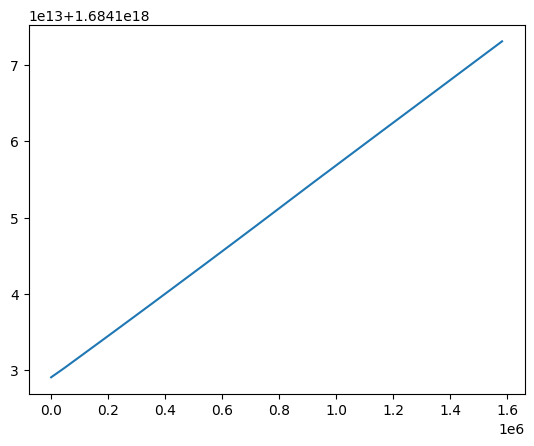

In [66]:
plt.figure()
plt.plot(_df.index)

In [61]:
_partition.compute()

,ATLAS:BUNCH_LUMI_INST,CMS:BUNCH_LUMI_INST,HC.TZ76.BLMDIAMOND2.5:AcquisitionIntegral:intSumBuf1,HC.TZ76.BLMDIAMOND3.5:AcquisitionIntegral:intSumBuf1,unix
1684129043964238525,None,None,None,None,1684129043964238525
1684129044000013856,None,None,None,None,1684129044000013856
1684129044000081432,None,None,None,None,1684129044000081432
1684129044000363275,None,None,None,None,1684129044000363275
1684129044011171000,None,None,None,"[585012, 594157, 575539, 583129, 566880, 57787...",1684129044011171000
...,...,...,...,...,...
1684173119845535000,None,None,None,None,1684173119845535000
1684173119858238525,None,None,None,None,1684173119858238525
1684173119859238525,None,None,None,None,1684173119859238525
1684173119860238525,None,None,None,None,1684173119860238525


In [37]:
(unix_e-unix_s)*1e-9/3600

18.289966756798613

In [28]:
display(pd.DataFrame(gc.get_stats()))

,collections,collected,uncollectable
0,709,2827,0
1,64,2648,0
2,5,133,0


In [25]:
LHC.Fill

'HX:FILLN'

In [29]:
test = dd.read_parquet(data_path + f'/HX:FILLN={fill}',columns=[LHC.Fill]).compute()
test.sort_index()

In [32]:
test.index[0]

1684128681470350000

In [52]:
for bmode_path in Path(data_path + f'/HX:FILLN={fill}').glob("*"):
    if 'STABLE' in str(bmode_path):
        print(bmode_path)

/home/phbelang/002_raw_data/HX:FILLN=8773/HX:BMODE=STABLE


In [50]:
bmode_path.contains('FIL')

AttributeError: 'PosixPath' object has no attribute 'contains'